<a href="https://colab.research.google.com/github/Nathan-Levy/Traffic-Flow-Prediction-in-Urban-Areas/blob/main/Emirates_Traffic_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from keras import layers
!pip install folium --q
import folium

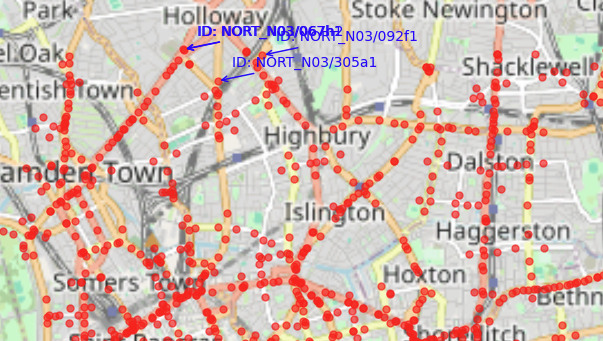

In [ ]:
emirates = pd.read_csv('Emirates.csv')

In [ ]:
emirates.dropna(how='all', inplace=True)

In [ ]:
emirates['day'] = pd.to_datetime(emirates['day'])

emirates['datetime'] = emirates['day'] + pd.to_timedelta(emirates['interval'], unit='s')

emirates.set_index("datetime", inplace=True)

# Keep only the relevant column
time_flow = emirates[['NORT_N03/092f1 flow', 'NORT_N03/305a1 flow', 'NORT_N03/067h2 flow']]

print(time_flow)

                     NORT_N03/092f1 flow  NORT_N03/305a1 flow  \
datetime                                                        
2015-09-25 00:00:00                108.0            348.00000   
2015-09-25 00:05:00                 60.0            240.00000   
2015-09-25 00:10:00                 24.0            204.00000   
2015-09-25 00:15:00                 96.0            336.00000   
2015-09-25 00:20:00                 48.0            252.00000   
...                                  ...                  ...   
2015-10-01 23:35:00                 96.0            206.06896   
2015-10-01 23:40:00                108.0            408.00000   
2015-10-01 23:45:00                 36.0            348.00000   
2015-10-01 23:50:00                 84.0            240.00000   
2015-10-01 23:55:00                 60.0            240.00000   

                     NORT_N03/067h2 flow  
datetime                                  
2015-09-25 00:00:00            228.00000  
2015-09-25 00:05:00      

In [ ]:
print(len(time_flow['NORT_N03/092f1 flow'].tolist()))

1910


In [ ]:
# Normalise
scaler = MinMaxScaler()
flow_normalised = scaler.fit_transform(time_flow)

In [ ]:
print(time_flow.shape)

(1910, 3)


In [ ]:
# Train and validation split
train = len(flow_normalised)*0.8
X_train, X_val, = flow_normalised[:int(train), :], flow_normalised[int(train):, :]

In [ ]:
def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 3
X_train, y_train = create_dataset(X_train, look_back)
X_val, y_val = create_dataset(X_val, look_back)

In [ ]:
print(X_train.shape)

(1525, 3, 3)


In [ ]:
# [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

In [ ]:
input_layer = keras.layers.Input(shape=(look_back, 3))
encoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = keras.layers.LSTM(32, activation='relu', return_sequences=False)(encoded)

# Decoder
decoded = keras.layers.RepeatVector(look_back)(encoded)
decoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = keras.layers.TimeDistributed(layers.Dense(3, activation='linear'))(decoded)

# Autoencoder Model
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3, 3)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 3, 64)               │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 3, 64)               │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 3, 3)                │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,851 (214.26 KB)

 Trainable params: 54,851 (214.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, validation_data=[X_val, X_val])

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.1347 - val_loss: 0.0447
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0323 - val_loss: 0.0281
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0166 - val_loss: 0.0165
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0105 - val_loss: 0.0142
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - val_loss: 0.0108
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - val_loss: 0.0083
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - val_loss: 0.0070
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0052 - val_loss: 0.0064
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0049 - val_loss: 0.0060
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0045 - val_loss: 0.0058
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0044 - val_loss: 0.0056
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0043 - 

In [ ]:
# Extract the encoder model
encoder = keras.models.Model(inputs=input_layer, outputs=encoded)

# Generate the encoded features
encoded_features = encoder.predict(X_train)
encoded_features_val = encoder.predict(X_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
# Define the prediction model
prediction_model = keras.models.Sequential()
prediction_model.add(keras.layers.Dense(16, activation='relu', input_dim=encoded_features.shape[1]))
prediction_model.add(keras.layers.Dense(8, activation='relu'))
prediction_model.add(keras.layers.Dense(3, activation='linear'))

# Compile the prediction model
prediction_model.compile(optimizer='adam', loss='mse')

# Train the prediction model
prediction_model.fit(encoded_features, y_train, epochs=20, validation_data=(encoded_features_val, y_val))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1044 - val_loss: 0.0305
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236 - val_loss: 0.0185
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150 - val_loss: 0.0165
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126 - val_loss: 0.0149
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 - val_loss: 0.0142
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114 - val_loss: 0.0141
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - val_loss: 0.0136
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - val_loss: 0.0131
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - val_loss: 0.0131
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - val_loss: 0.0128
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0130
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - val_loss: 0.0127


In [ ]:
# Use the prediction model to make predictions
y_pred = prediction_model.predict(encoded_features_val)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
temp_val_1 = np.zeros((y_val.shape[0], 3))
temp_pred_1 = np.zeros((y_pred.shape[0], 3))

temp_val_1[:, 0] = y_val[:, 0]
temp_pred_1[:, 0] = y_pred[:, 0]

y_val_detector_1 = temp_val_1[:, 0]
y_pred_detector_1 = temp_pred_1[:, 0]

In [ ]:
temp_val_2 = np.zeros((y_val.shape[0], 3))
temp_pred_2 = np.zeros((y_pred.shape[0], 3))

temp_val_2[:, 1] = y_val[:, 1]
temp_pred_2[:, 1] = y_pred[:, 1]

y_val_detector_2 = temp_val_2[:, 1]
y_pred_detector_2 = temp_pred_2[:, 1]

In [ ]:
temp_val_3 = np.zeros((y_val.shape[0], 3))
temp_pred_3 = np.zeros((y_pred.shape[0], 3))

temp_val_3[:, 2] = y_val[:, 2]
temp_pred_3[:, 2] = y_pred[:, 2]

y_val_detector_3 = temp_val_3[:, 2]
y_pred_detector_3 = temp_pred_3[:, 2]

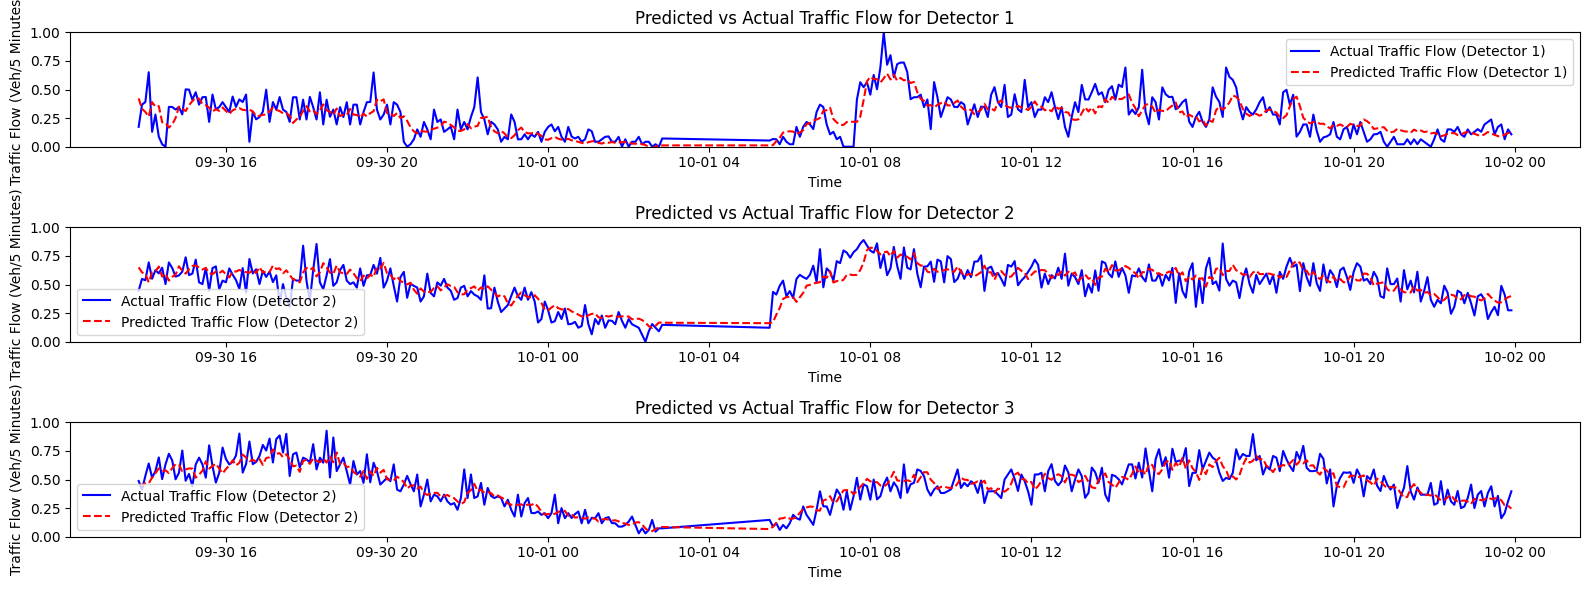

In [ ]:
import matplotlib.pyplot as plt

timestamps = time_flow.index[-len(y_val):]

# Define figure and axes for side-by-side plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 6))  # 3 rows, 1 column

# First plot on ax1 (Actual vs Predicted for Detector 1)
ax1.plot(timestamps, y_val_detector_1, label='Actual Traffic Flow (Detector 1)', color='blue')
ax1.plot(timestamps, y_pred_detector_1, label='Predicted Traffic Flow (Detector 1)', color='red', linestyle='--')
ax1.set_xlabel('Time')
ax1.set_ylabel('Traffic Flow (Veh/5 Minutes)')
ax1.set_title('Predicted vs Actual Traffic Flow for Detector 1')
ax1.legend()

# Second plot on ax2 (Actual vs Predicted for Detector 2)
ax2.plot(timestamps, y_val_detector_2, label='Actual Traffic Flow (Detector 2)', color='blue')
ax2.plot(timestamps, y_pred_detector_2, label='Predicted Traffic Flow (Detector 2)', color='red', linestyle='--')
ax2.set_xlabel('Time')
ax2.set_ylabel('Traffic Flow (Veh/5 Minutes)')
ax2.set_title('Predicted vs Actual Traffic Flow for Detector 2')
ax2.legend()

# Third plot on ax3 (Actual vs Predicted for Detector 3)
ax3.plot(timestamps, y_val_detector_3, label='Actual Traffic Flow (Detector 2)', color='blue')
ax3.plot(timestamps, y_pred_detector_3, label='Predicted Traffic Flow (Detector 2)', color='red', linestyle='--')
ax3.set_xlabel('Time')
ax3.set_ylabel('Traffic Flow (Veh/5 Minutes)')
ax3.set_title('Predicted vs Actual Traffic Flow for Detector 3')
ax3.legend()

# # Set the y-axis limits for both plots
ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()


In [ ]:
from folium.plugins import HeatMapWithTime
import folium
import pandas as pd
import numpy as np

# Sample time_flow DataFrame
# Ensure that your actual DataFrame has a timestamp index and valid flow data
time_flow = pd.DataFrame({
    "NORT_N03/092f1 Flow": time_flow['NORT_N03/092f1 flow'].tolist(),
    "NORT_N03/305a1 Flow": time_flow['NORT_N03/305a1 flow'].tolist(),
    "NORT_N03/067h2 Flow": time_flow['NORT_N03/067h2 flow'].tolist()
}, index=pd.date_range("2015-09-25", periods=1910, freq="5T"))

detector_locations = {
    "NORT_N03/092f1": (51.553475, -0.111087),
    "NORT_N03/305a1": (51.551011, -0.117993),
    "NORT_N03/067h2": (51.554015, -0.12324)
}

# Normalize flow values
# max_flow = time_flow.max().max()
# time_flow = time_flow / max_flow  # Scale between 0-1

# Prepare Heatmap Data
heatmap_data = []
for timestamp, row in time_flow.iterrows():
    time_slot = []
    for column, flow_value in row.items():
        detector_id = column.split()[0]
        if detector_id in detector_locations:
            lat, lon = detector_locations[detector_id]
            time_slot.append([lat, lon, flow_value])
    heatmap_data.append(time_slot)

# Flatten the data
flattened_data = []
for timestamp, time_slot in zip(time_flow.index, heatmap_data):
    for lat, lon, weight in time_slot:
        flattened_data.append([timestamp, lat, lon, weight])

# Create DataFrame
df_heatmap = pd.DataFrame(flattened_data, columns=["Timestamp", "Latitude", "Longitude", "Weight"])

# Convert Timestamp to datetime and sort
df_heatmap['Timestamp'] = pd.to_datetime(df_heatmap['Timestamp'])
df_heatmap = df_heatmap.sort_values(by="Timestamp")

# Prepare data for HeatMapWithTime
time_index = list(df_heatmap['Timestamp'].astype(str).unique())

data = []
for _, d in df_heatmap.groupby('Timestamp'):
    data.append([[row['Latitude'], row['Longitude'], row['Weight']] for _, row in d.iterrows()])

hmt = folium.Map(location=[51.554867, -0.109112],
                tiles="cartodbpositron",
                zoom_start=15,
                control_scale=True)

HeatMapWithTime(data,
                index=time_index,
                auto_play=True,
                use_local_extrema=True
               ).add_to(hmt)

hmt


<ipython-input-113-0ed1437d8efa>:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  }, index=pd.date_range("2015-09-25", periods=1910, freq="5T"))
